In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim

In [2]:
path = 'D:/JOB PREP/Projects/Data Science at British Airways/'
df = pd.read_csv(path+"data/BA_reviews_processed.csv")
df.head()

,reviews
0,worst cabin experience ever cramped seat low c...
1,first time flying british airway first time fl...
2,latest affront stood first class line hour fin...
3,booked flight return flight london munich dece...
4,tried check line informed possible given reaso...


list of the top words used across all reviews

In [3]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a review and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

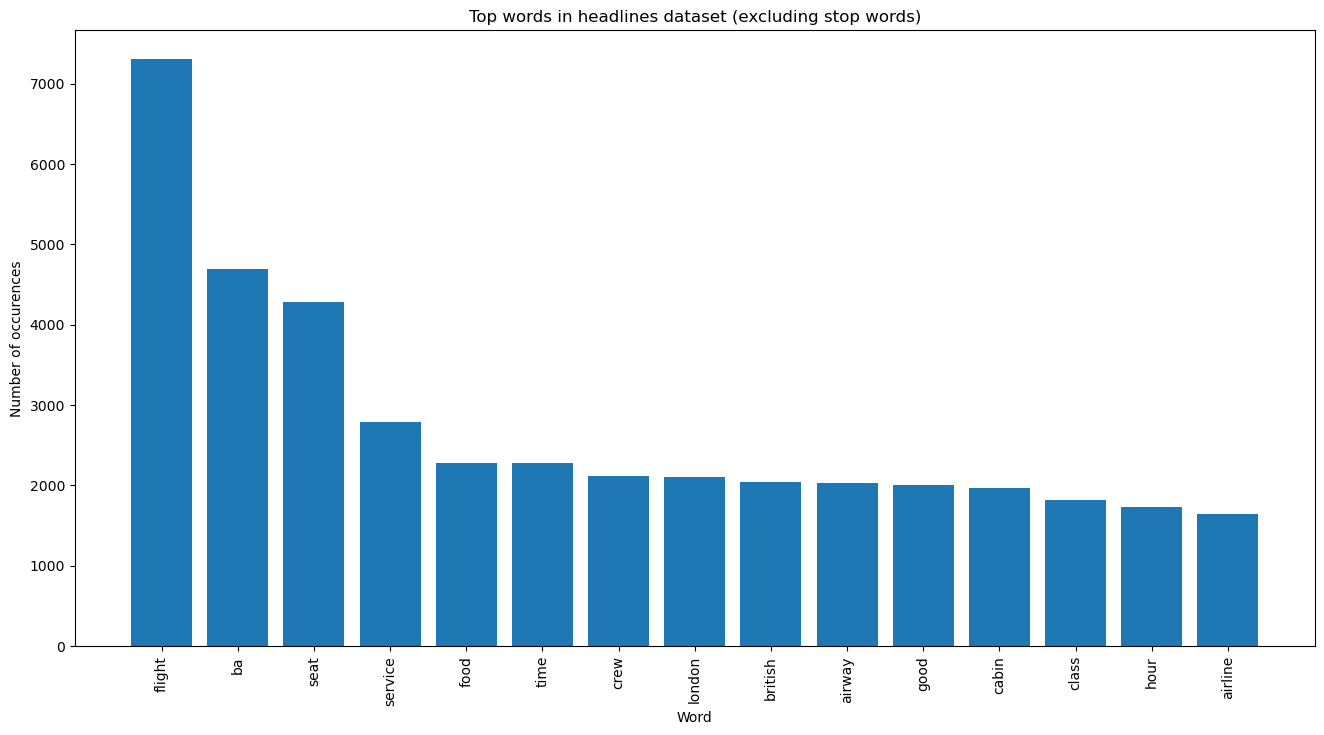

In [4]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['reviews'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

The frequency chart shows that the key topics within the
reviews include “service”, “seat”, “crew” and “food”, showing that
people are actively talking about their experience and food.

we generate a histogram of review word lengths, and use part-of-speech tagging to understand the types of words used across the corpus. This requires first converting all review strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each review.

In [5]:
tagged_headlines = [TextBlob(df['reviews'][i]).pos_tags for i in range(df['reviews'].shape[0])]

In [6]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per review: ', np.mean(word_counts))

Total number of words:  289915
Mean number of words per review:  82.95135908440629


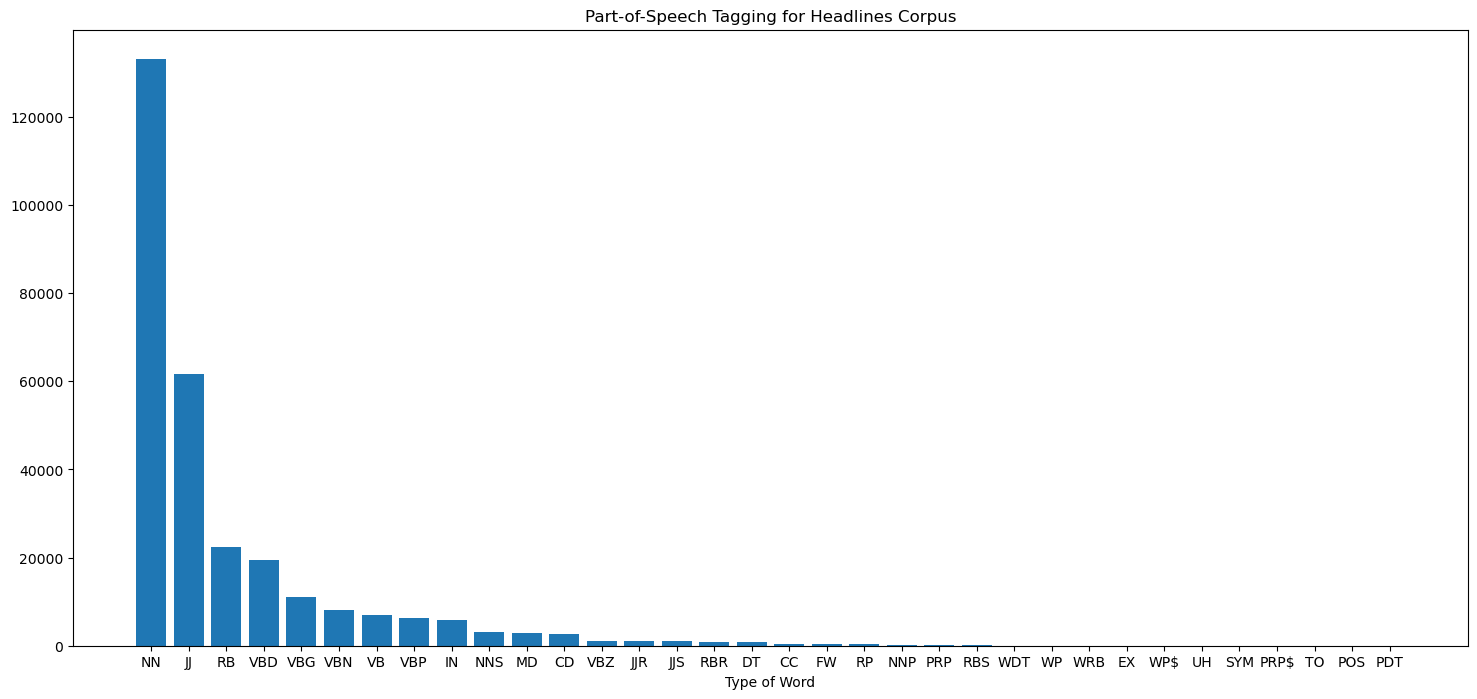

In [7]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        deacc=True #removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.reviews.values.tolist()
data_words = list(sent_to_words(data))

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
len(texts)

3495

In [11]:
len(corpus)

3495

In [12]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"flight" + 0.016*"seat" + 0.011*"ba" + 0.010*"cabin" + 0.009*"time" + '
  '0.008*"hour" + 0.008*"service" + 0.007*"crew" + 0.007*"british" + '
  '0.007*"airway"'),
 (1,
  '0.031*"flight" + 0.018*"ba" + 0.009*"london" + 0.009*"seat" + '
  '0.008*"service" + 0.008*"time" + 0.006*"one" + 0.006*"would" + 0.006*"food" '
  '+ 0.006*"staff"'),
 (2,
  '0.017*"flight" + 0.016*"ba" + 0.014*"british" + 0.013*"airway" + '
  '0.009*"airline" + 0.009*"seat" + 0.008*"london" + 0.007*"food" + '
  '0.007*"one" + 0.006*"time"'),
 (3,
  '0.015*"ba" + 0.015*"flight" + 0.012*"seat" + 0.010*"service" + '
  '0.009*"class" + 0.009*"cabin" + 0.007*"airway" + 0.007*"british" + '
  '0.007*"food" + 0.006*"business"'),
 (4,
  '0.018*"flight" + 0.018*"seat" + 0.010*"ba" + 0.009*"food" + 0.009*"one" + '
  '0.008*"cabin" + 0.008*"service" + 0.008*"business" + 0.008*"time" + '
  '0.007*"staff"'),
 (5,
  '0.029*"flight" + 0.016*"seat" + 0.015*"ba" + 0.013*"class" + 0.012*"crew" + '
  '0.008*"cabin" + 0.00

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

C:\Users\anjal\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.004045  0.003282       1        1  29.134657
5      0.015548  0.008831       2        1  13.728011
9     -0.007523  0.004032       3        1   9.683506
4      0.006723  0.001614       4        1   9.515554
0     -0.006338  0.000189       5        1   8.200378
8     -0.006471  0.005963       6        1   8.001476
7      0.004188  0.007634       7        1   7.324735
1     -0.012293  0.009242       8        1   7.138622
2     -0.017783 -0.021283       9        1   5.406456
3      0.019904 -0.019502      10        1   1.866605, topic_info=        Term         Freq        Total Category  logprob  loglift
11    flight  7161.000000  7161.000000  Default  30.0000  30.0000
1         ba  4563.000000  4563.000000  Default  29.0000  29.0000
17      seat  4191.000000  4191.000000  Default  28.0000  28.0000
35   british  1968.000000  1968.000000  Default  27.0000  27.0000
28    airway  1943.000000  1943.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
68    london    26.316862  2059.095765  Topic10  -5.3196  -0.3788
46   economy    21.486698  1359.760199  Topic10  -5.5224  -0.1666
292     good    23.554809  2035.362339  Topic10  -5.4305  -0.4781
151      get    18.428824  1239.236447  Topic10  -5.6759  -0.2273
99     staff    17.670650  1426.173183  Topic10  -5.7179  -0.4098

[822 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11992      6  0.588235  ablebodied
5237       8  0.569012    abundant
534        1  0.236492      access
534        2  0.274636      access
534        3  0.076288      access
...      ...       ...         ...
971       10  0.028021        year
2025       6  0.565841          yo
3073       1  0.283390      zrhlhr
3073       6  0.283390      zrhlhr
3073       7  0.566780      zrhlhr

[2079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 10, 5, 1, 9, 8, 2, 3, 4])